# Challenge 1: Integrating Farmer and Weather Data Sets

## Overview

This notebook contains an analysis of historical weather patterns, ERA5 data, and the specific questions asked by smallholder farmers in Kenya, Uganda, and Tanzania. This notebook looks at rainfall anomalies and heat stress to determine trends in farmer questions topics, specifically looking at 'Pests & Disease' topics.

In [2]:
import os
import re
import duckdb
import sklearn
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Importing and setting path files to already translated parquet files and era5 country data.
current_directory = Path(os.getcwd())

root_directory = current_directory.joinpath('../..')

original_parquet_path = root_directory.joinpath('data/b0cd514b-b9cc-4972-a0c2-c91726e6d825.parquet')

# split data file paths
eng_parquet_path = root_directory.joinpath('data/eng.parquet')
# already sampled to obtain 0.5 percent of data of each language
swa_parquet_path = root_directory.joinpath('data/swa_translated_sample.parquet')
lug_parquet_path = root_directory.joinpath('data/lug_translated_sample.parquet')
nyn_parquet_path = root_directory.joinpath('data/nyn_translated_sample.parquet')

# split era5 data with tasmax, tasmin and prcp information for each country
kenya_era5_path = root_directory.joinpath('data/era5_kenya.xlsx')
tanzania_era5_path = root_directory.joinpath('data/era5_tanzania.xlsx')
uganda_era5_path = root_directory.joinpath('data/era5_uganda.xlsx')


path_list = [swa_parquet_path, lug_parquet_path, nyn_parquet_path]
era5_map = {
    'KE': kenya_era5_path, 
    'TZ': tanzania_era5_path, 
    'UG': uganda_era5_path}

## Cleaning, Inspecting and Finalizing Topics via NLTK and LDA

In [4]:
# Obtaining 0.5 percent of the English parquet data file and 
# concatenating all files with selected columns into one data frame.
conn = duckdb.connect()

data_frames = []
sample_query = f"""
    SELECT question_id, question_content AS eng_content, question_user_country_code, question_sent, question_topic,
    FROM read_parquet('{eng_parquet_path}')
    USING SAMPLE 0.5% (bernoulli)
"""

eng_sample_df = conn.execute(sample_query).fetchdf()
data_frames.append(eng_sample_df)

for paths in path_list:
    df_transl = pd.read_parquet(paths)

    conn.register('translated_sample', df_transl)
    
    df = conn.execute(f"""
        SELECT 
            translated_sample.question_id,
            translated_sample.question_content,
            translated_sample.translated_en AS eng_content,
            translated_sample.src_lang,
            original_sample.question_user_country_code,
            original_sample.question_sent,
            original_sample.question_topic,
        FROM translated_sample
        LEFT JOIN read_parquet('{original_parquet_path}') AS original_sample 
        ON translated_sample.question_id = original_sample.question_id     
    """).fetchdf()
    
    data_frames.append(df)

conn.close()

all_df = pd.concat(data_frames, ignore_index=True)
all_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,question_id,eng_content,question_user_country_code,question_sent,question_topic,question_content,src_lang
0,19894872,Q. Farming needs fertile land.Am selling my 1....,ke,2018-12-21 16:30:31.52963+00,banana,NaN,NaN
1,16366168,justine asks:how can istart plant potatoes ine...,2018-11-21 09:04:51.224271+00,2018-11-21 08:46:19.80276+00,plant,NaN,NaN
2,34607810,Q. How can plant managu and ensure that i get ...,ke,2019-11-23 11:06:18.886577+00,plant,NaN,NaN
3,36905048,how do i boost flowering in my tomatoes?,ke,2020-01-27 18:20:25.833758+00,tomato,NaN,NaN
4,37109466,Q.whch type of crops can i plant during this r...,ke,2020-02-03 17:53:32.628632+00,crop,NaN,NaN
...,...,...,...,...,...,...,...
355247,57920950,The farmer has two hundred thousand shillings ...,ug,2021-08-01 13:15:44.542324-07:00,passion-fruit,E omuhiingi nagira obutunda ndunde ibiri notek...,nyn
355248,57920950,The farmer has two hundred thousand shillings ...,ug,2021-08-01 13:15:44.542324-07:00,passion-fruit,E omuhiingi nagira obutunda ndunde ibiri notek...,nyn
355249,57920950,The farmer has two hundred thousand shillings ...,ug,2021-08-01 13:15:44.542324-07:00,passion-fruit,E omuhiingi nagira obutunda ndunde ibiri notek...,nyn
355250,57926780,Why should we use the product in this country?,ug,2021-08-01 23:58:51.370128-07:00,bean,E naba ninyenda kubyara ebinyobwa nebihimba om...,nyn


In [5]:
# Cleaning and lemmatizing via NLTK

# adding known hallucination words from looking at translated languages question content.

hallucination_words = ['attorney', 'general', 'prime', 'minister', 'parliament', 'football', 
    'premier', 'league', 'musician', 'contract', 'sinnin', 'guyaya', 
    'qipssss', 'aiiiiii']

updated_stops = [
    'want', 'ask', 'asks', 'help', 'question', 'fine', 'good', 'best', 
    'know', 'person', 'tell', 'thank', 'thanks', 'hello', 'dear', 'sir',
    'please', 'like', 'need',  'man', 'mother', 'brother', 'sister', 'body', 
    'piece', 'single', 'game', 'clean', 'filled', 'helping', 'search', 'pain', 
    'called', 'dont', 'start', 'day', 'world', 'thing', 'use', 'farmer', 'plant', 'planting'
]
custom_stops = set(stopwords.words('english'))
custom_stops.update(hallucination_words)
custom_stops.update(updated_stops)

lemmatizer = WordNetLemmatizer()

def clean_text(text): 
    text = str(text).lower()
    # replacing any punctuation
    text = re.sub(r'(.)\1{2,}', '', text)
    # split text and check select words not in custom_stops
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()

    clean_tokens = []
    for t in tokens:
        if t in custom_stops:
            continue
            
        if len(t) < 3 or len(t) > 12:
            continue
            
        # lemmatize words
        lemma = lemmatizer.lemmatize(t)
        
        if lemma not in custom_stops:
            clean_tokens.append(lemma)

    return " ".join(clean_tokens)

all_df['clean_eng_content'] = all_df['eng_content'].apply(clean_text)
all_df.head(5)

,question_id,eng_content,question_user_country_code,question_sent,question_topic,question_content,src_lang,clean_eng_content
0,19894872,Q. Farming needs fertile land.Am selling my 1....,ke,2018-12-21 16:30:31.52963+00,banana,NaN,NaN,farming fertile landam selling acre three hous...
1,16366168,justine asks:how can istart plant potatoes ine...,2018-11-21 09:04:51.224271+00,2018-11-21 08:46:19.80276+00,plant,NaN,NaN,justine askshow istart potato ineed
2,34607810,Q. How can plant managu and ensure that i get ...,ke,2019-11-23 11:06:18.886577+00,plant,NaN,NaN,managu ensure get yield produce observe gain t...
3,36905048,how do i boost flowering in my tomatoes?,ke,2020-01-27 18:20:25.833758+00,tomato,NaN,NaN,boost flowering tomato
4,37109466,Q.whch type of crops can i plant during this r...,ke,2020-02-03 17:53:32.628632+00,crop,NaN,NaN,qwhch type crop rainy season


In [6]:
# Using LDA to investigate and inspect topic themes
clean_text = all_df['clean_eng_content'].fillna("").astype(str).tolist()

vectorizer = CountVectorizer(max_df=0.9, min_df=20, stop_words=list(custom_stops))
dtm = vectorizer.fit_transform(clean_text)

lda_model = LatentDirichletAllocation(n_components=4, random_state=42)
lda_output = lda_model.fit_transform(dtm)

def show_lda_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        term_list = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict[f"Topic {topic_idx}"] = term_list
        print(f"Topic {topic_idx}:")
        print(" ".join(term_list))
    return topic_dict

feature_names = vectorizer.get_feature_names_out()
topics = show_lda_topics(lda_model, feature_names, 10)

Topic 0:
get tomato still pregnant nza wingssa would kuika singal medicine
Topic 1:
rain back downpour farm goat get hundred banana benard soaa
Topic 2:
chicken corn seed maize whole cow crop chick bean much
Topic 3:
kanga edamama many rabbit egg long take meaning corn market


In [7]:
# Finalizing Topics by inspecting each row.
def define_keyword_category(row):
    combined_text = str(row['question_topic']).lower() + " " + str(row['clean_eng_content']).lower()

    bad_labels = ['other', 'none', 'nan', 'general']

    if any(x in combined_text for x in ['pest', 'worm', 'insect', 'beetle', 'locust', 'dudu', 'armyworm', 'tick', 'mite', 'disease', 'sick', 'wilt', 'rot', 'blight', 'fungus']): 
        return 'Pests & Disease'

    if any(x in combined_text for x in ['rain', 'downpour', 'drought', 'water', 'flood', 'weather', 'sun', 'dry', 'climate', 'season']): 
        return 'Weather'

    if any(x in combined_text for x in ['price', 'market', 'sell', 'buy', 'cost', 'shilling', 'money', 'profit', 'loan']): 
        return 'Market'

    if any(x in combined_text for x in ['cow', 'goat', 'chicken', 'milk', 'egg', 'hen', 'bull', 'calf', 'animal', 'poultry', 'cattle', 'livestock']): 
        return 'Livestock'

    if any(x in combined_text for x in ['maize', 'corn', 'bean', 'seed', 'plant', 'harvest', 'garden', 'farm', 'fertilizer', 'tomato', 'potato', 'cassava', 'coffee', 'vegetable', 'onion']): 
        return 'Crops'

    return 'Other'

all_df['final_category'] = all_df.apply(define_keyword_category, axis=1)
print(all_df['final_category'].value_counts())

final_category
Crops              105056
Livestock          100403
Other               92587
Weather             33324
Market              12352
Pests & Disease     11530
Name: count, dtype: int64


## Integrating Farmer and Weather (ERA5) Data

In [8]:
# Cleaning and removing missing values.
all_df['question_sent'] = pd.to_datetime(all_df['question_sent'], utc=True, format='ISO8601', errors='coerce')
all_df['month_key'] = all_df['question_sent'].dt.tz_localize(None).dt.to_period('M')

if 'src_lang' in all_df.columns:
    mask_ug = (all_df['question_user_country_code'].isna()) & (all_df['src_lang'].isin(['lug', 'nyn']))
    all_df.loc[mask_ug, 'question_user_country_code'] = 'UG'

before_len = len(all_df)
cleaned_df = all_df.dropna(subset=['question_user_country_code', 'question_sent']).copy()
after_len = len(cleaned_df)

print(f"Dropped {before_len - after_len} rows due to missing Date/Location info.")
print(f"Remaining Rows: {len(all_df)}")

cleaned_df['question_user_country_code'] = cleaned_df['question_user_country_code'].astype(str).str.lower().str.strip()
country_map = {
    'ke': 'KE', 'ken': 'KE', 'kenya': 'KE', 
    'ug': 'UG', 'uga': 'UG', 'uganda': 'UG', 
    'tz': 'TZ', 'tza': 'TZ', 'tanzania': 'TZ'
}

cleaned_df['question_user_country_code'] = cleaned_df['question_user_country_code'].map(country_map)
cleaned_df = cleaned_df.dropna(subset=['question_user_country_code'])

print("Rows after Country Cleanup:", len(cleaned_df))

Dropped 1452 rows due to missing Date/Location info.
Remaining Rows: 355252
Rows after Country Cleanup: 353785


In [9]:
# Grouping all monthly question topics. 
monthly_questions_df = cleaned_df.groupby(['question_user_country_code', 
                                           'month_key', 'final_category']).size().reset_index(name='question_count')
monthly_questions_df

,question_user_country_code,month_key,final_category,question_count
0,KE,2017-11,Crops,100
1,KE,2017-11,Livestock,175
2,KE,2017-11,Market,10
3,KE,2017-11,Other,92
4,KE,2017-11,Pests & Disease,17
...,...,...,...,...
788,UG,2021-09,Livestock,52
789,UG,2021-09,Market,18
790,UG,2021-09,Other,180
791,UG,2021-09,Pests & Disease,16


In [10]:
# Reading ERA5 files and combining into one dataframe.
def process_excel_file(path, country_code):
    xlsx_file = pd.ExcelFile(path)

    def load_sheet(sheet_number, value_name): 
        df = pd.read_excel(xlsx_file, sheet_name=sheet_number)
        df_melt = pd.melt(
            df, 
            id_vars = ['code', 'name'],
            var_name = 'date',
            value_name = value_name
        )

        return df_melt

    df_prcp = load_sheet(0, 'prcp')
    df_tasmax = load_sheet(1, 'tasmax')
    df_tasmin = load_sheet(2, 'tasmin')

    df_combined = pd.merge(df_prcp, df_tasmax, on=['code', 'name', 'date'])
    df_combined = pd.merge(df_combined, df_tasmin, on=['code', 'name', 'date'])

    df_combined['code'] = country_code
    df_combined['date'] = pd.to_datetime(df_combined['date'])

    return df_combined

weather_dfs = []

for path_country, path in era5_map.items(): 
    df_country = process_excel_file(path, path_country)
    weather_dfs.append(df_country)

weather_combined_df = pd.concat(weather_dfs, ignore_index=True)

df_weather_final = weather_combined_df.groupby(['code', 'date']).agg({
    'prcp': 'mean',
    'tasmax': 'mean',
    'tasmin': 'mean'
}).reset_index()

df_weather_final['month_key'] = df_weather_final['date'].dt.to_period('M')

In [11]:
# Adding monthly lags to weather data before merging.
df_weather_final = df_weather_final.sort_values(['code', 'date'])

# Shows a month agos prcp shift
df_weather_final['prcp_lag1'] = df_weather_final.groupby('code')['prcp'].shift(1) 
# Shows two month agos prcp shift
df_weather_final['prcp_lag2'] = df_weather_final.groupby('code')['prcp'].shift(2)
# Shows two month agos tasmax shift
df_weather_final['tasmax_lag1'] = df_weather_final.groupby('code')['tasmax'].shift(1)

df_weather_final.head(5)

,code,date,prcp,tasmax,tasmin,month_key,prcp_lag1,prcp_lag2,tasmax_lag1
0,KE,1950-01-01,46.34,30.40,20.11,1950-01,NaN,NaN,NaN
1,KE,1950-02-01,21.06,31.79,20.43,1950-02,46.34,NaN,30.40
2,KE,1950-03-01,138.63,29.45,20.37,1950-03,21.06,46.34,31.79
3,KE,1950-04-01,219.78,27.17,19.92,1950-04,138.63,21.06,29.45
4,KE,1950-05-01,120.62,26.49,19.18,1950-05,219.78,138.63,27.17


In [12]:
# Calculating anomalies
df_weather_final['month_num'] = df_weather_final['date'].dt.month

# calculating 'normal' values
climatology = df_weather_final.groupby(['code', 'month_num'])[['prcp', 'tasmax']].mean().reset_index()
climatology = climatology.rename(columns={'prcp': 'prcp_normal', 'tasmax': 'tasmax_normal'})

df_weather_final = pd.merge(df_weather_final, climatology, on=['code', 'month_num'], how='left')
# calculating differences from normal
df_weather_final['prcp_anomaly'] = df_weather_final['prcp'] - df_weather_final['prcp_normal']
df_weather_final['tasmax_anomaly'] = df_weather_final['tasmax'] - df_weather_final['tasmax_normal']

# filtering for analysis periods
start_date = '2017-01-01'
df_weather_modeling = df_weather_final[df_weather_final['date'] >= start_date].copy()
df_weather_modeling['month_key'] = df_weather_modeling['date'].dt.to_period('M')
df_weather_modeling['year'] = df_weather_modeling['date'].dt.to_period('Y')
df_weather_modeling.head(5)

,code,date,prcp,tasmax,tasmin,month_key,prcp_lag1,prcp_lag2,tasmax_lag1,month_num,prcp_normal,tasmax_normal,prcp_anomaly,tasmax_anomaly,year
804,KE,2017-01-01,9.42,32.65,20.29,2017-01,34.02,85.57,31.06,1,39.691781,31.129726,-30.271781,1.520274,2017
805,KE,2017-02-01,17.90,32.66,21.75,2017-02,9.42,34.02,32.65,2,33.510685,32.142603,-15.610685,0.517397,2017
806,KE,2017-03-01,23.86,33.94,22.76,2017-03,17.90,9.42,32.66,3,72.496712,31.957671,-48.636712,1.982329,2017
807,KE,2017-04-01,68.79,32.40,22.73,2017-04,23.86,17.90,33.94,4,128.040548,30.212055,-59.250548,2.187945,2017
808,KE,2017-05-01,96.74,30.49,21.78,2017-05,68.79,23.86,32.40,5,88.757945,29.491233,7.982055,0.998767,2017


In [13]:
# Merging with farmer's questions to get final dataframe.
df_final_analysis = pd.merge(
    monthly_questions_df,  
    df_weather_modeling,    
    left_on=['question_user_country_code', 'month_key'],
    right_on=['code', 'month_key'],
    how='inner'
)
df_final_analysis

,question_user_country_code,month_key,final_category,question_count,code,date,prcp,tasmax,tasmin,prcp_lag1,prcp_lag2,tasmax_lag1,month_num,prcp_normal,tasmax_normal,prcp_anomaly,tasmax_anomaly,year
0,KE,2017-11,Crops,100,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
1,KE,2017-11,Livestock,175,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
2,KE,2017-11,Market,10,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
3,KE,2017-11,Other,92,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
4,KE,2017-11,Pests & Disease,17,KE,2017-11-01,105.83,29.70,21.13,90.05,50.03,31.45,11,103.701233,29.388767,2.128767,0.311233,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,UG,2021-09,Livestock,52,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021
789,UG,2021-09,Market,18,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021
790,UG,2021-09,Other,180,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021
791,UG,2021-09,Pests & Disease,16,UG,2021-09-01,193.56,27.08,18.98,112.97,80.20,27.62,9,154.462192,26.890274,39.097808,0.189726,2021


## Farmer Questions and ERA5 Visualizations

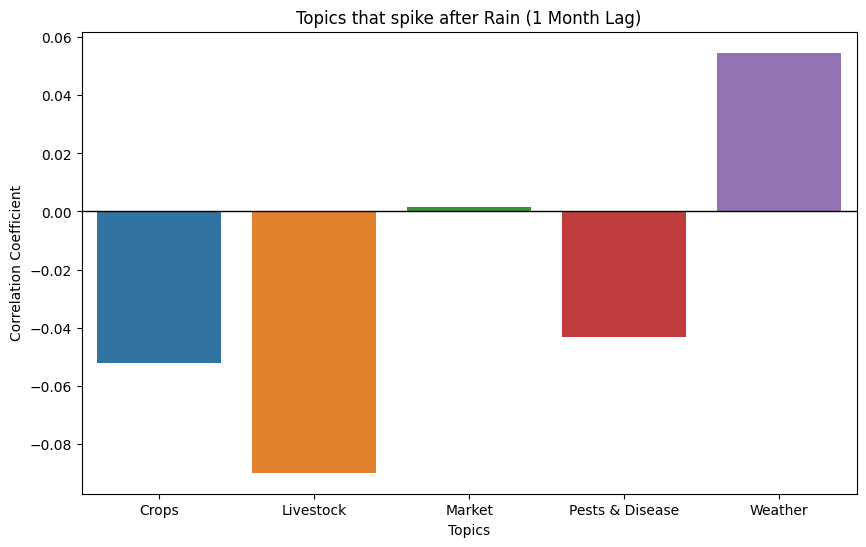

In [14]:
# Visualizing correlation with lagged precipitation 
df_corr_init =  df_final_analysis.pivot_table(
    index=['question_user_country_code', 'month_key', 'prcp', 'prcp_lag1', 'tasmax'],
    columns='final_category',
    values='question_count',
    fill_value=0
).reset_index()

prcp_lag_correlations = df_corr_init.corr(numeric_only=True)['prcp_lag1']

plt.figure(figsize=(10, 6))

topic_columns = ['Crops', 'Livestock', 'Market', 'Pests & Disease', 'Weather']
sns.barplot(x=prcp_lag_correlations[topic_columns].index, y=prcp_lag_correlations[topic_columns].values, hue=prcp_lag_correlations[topic_columns].index)
plt.axhline(0, color='black', linewidth=1)
plt.title("Topics that spike after Rain (1 Month Lag)")
plt.xlabel("Topics")
plt.ylabel("Correlation Coefficient")
plt.show()

In [15]:
# Inspecting Kenya to check if multiple countries caused low correlation scores in previous cell.
ke_data = df_final_analysis[df_final_analysis['question_user_country_code'] == 'KE'].copy()
ke_pivot =  ke_data.pivot_table(
    index='month_key',
    columns='final_category',
    values='question_count',
    fill_value=0
)

ke_weather = ke_data[['month_key', 'prcp_lag1']].drop_duplicates().set_index('month_key')
ke_check = pd.concat([ke_pivot, ke_weather], axis=1)

print("Correlation in Kenya Only:")
print(ke_check.corr(numeric_only=True)['prcp_lag1'])

Correlation in Kenya Only:
Crops             -0.142142
Livestock         -0.057144
Market            -0.088783
Other              0.051704
Pests & Disease   -0.032546
Weather           -0.147750
prcp_lag1          1.000000
Name: prcp_lag1, dtype: float64


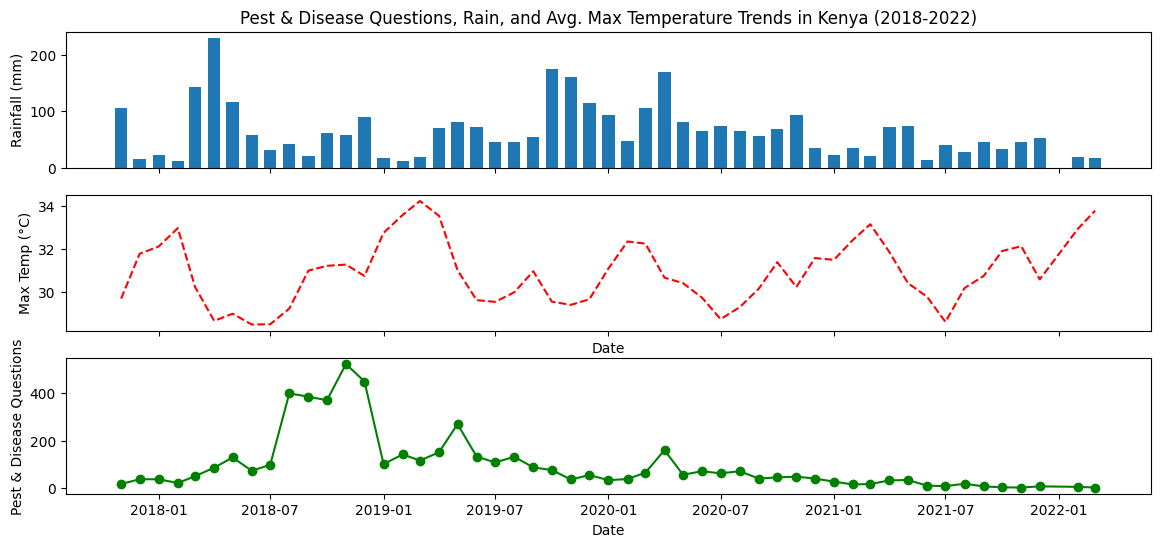

In [16]:
# Visualizing Pest Questions and Rain in Kenya
pest_plot_df = df_final_analysis[
    (df_final_analysis['question_user_country_code'] == 'KE') & 
    (df_final_analysis['final_category'] == 'Pests & Disease')
].copy()

fig, axs = plt.subplots(3, 1, sharex = True, figsize=(14, 6))

axs[0].set_title('Pest & Disease Questions, Rain, and Avg. Max Temperature Trends in Kenya (2018-2022)')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].bar(pest_plot_df['date'], pest_plot_df['prcp'], label='Rainfall', width=20)

axs[1].set_xlabel('Date')
axs[1].set_ylabel('Max Temp (°C)')
axs[1].plot(pest_plot_df['date'], pest_plot_df['tasmax'],  color='red', linestyle='--', label='Max Temp')

axs[2].set_xlabel('Date')
axs[2].set_ylabel('Pest & Disease Questions')
axs[2].plot(pest_plot_df['date'], pest_plot_df['question_count'], color= 'green', marker='o', label='Pest Questions')

plt.show()

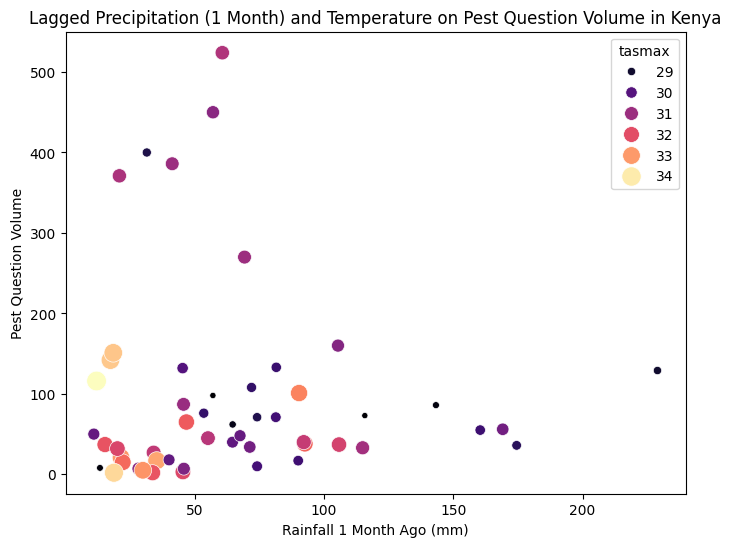

In [17]:
# Visualizing scatter plot of Lagged Rainfall, Temperature on Pest & Disease Questions
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pest_plot_df, 
                x='prcp_lag1', 
                y='question_count', 
                size='tasmax', sizes=(20, 200), hue='tasmax', palette='magma')
plt.title("Lagged Precipitation (1 Month) and Temperature on Pest Question Volume in Kenya")
plt.xlabel("Rainfall 1 Month Ago (mm)")
plt.ylabel("Pest Question Volume")
plt.show()

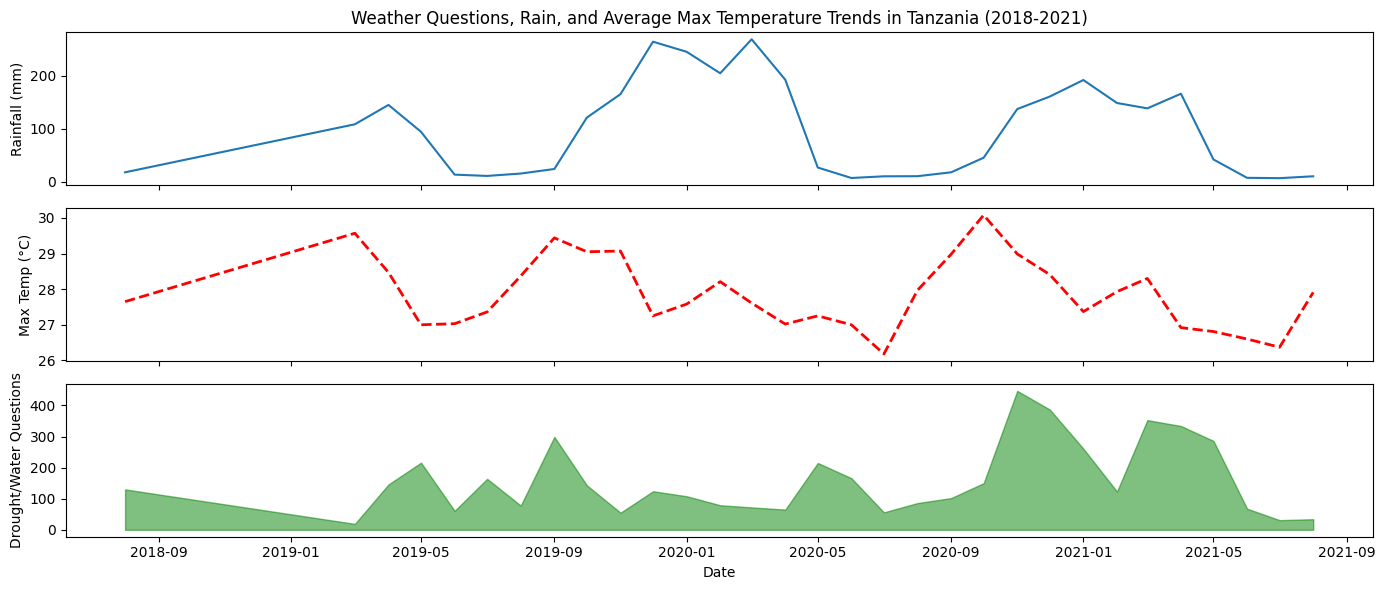

In [18]:
# Visualizing Weather Question Trends in Tanzania
weather_plot_df = df_final_analysis[
    (df_final_analysis['code'] == 'TZ') & 
    (df_final_analysis['final_category'] == 'Weather')
].copy()

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(14, 6))

axs[0].set_title('Weather Questions, Rain, and Average Max Temperature Trends in Tanzania (2018-2021)')
axs[0].set_ylabel('Rainfall (mm)')
axs[0].plot(weather_plot_df['date'], weather_plot_df['prcp'], label='Rainfall')

axs[1].set_ylabel('Max Temp (°C)')
axs[1].plot(weather_plot_df['date'], weather_plot_df['tasmax'], color='red', linestyle='--', linewidth=2, label='Max Temp')

axs[2].set_xlabel('Date')
axs[2].set_ylabel('Drought/Water Questions')
axs[2].fill_between(weather_plot_df['date'], weather_plot_df['question_count'], color='green', alpha=0.5, label='Weather Question')

fig.tight_layout()
plt.show()

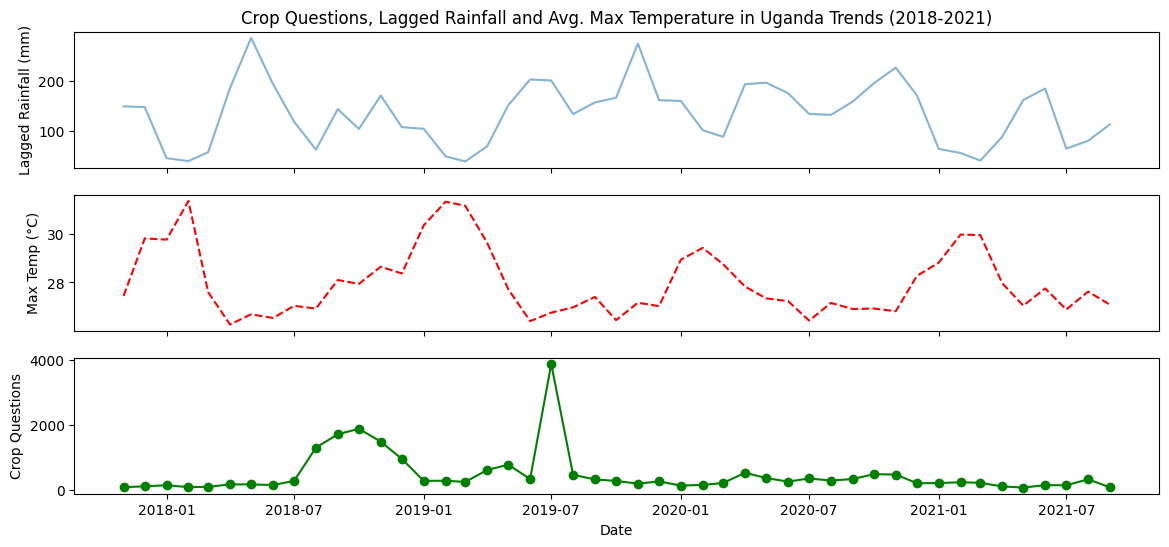

In [19]:
# Visualizing Crop Questions in Uganda
crop_plot_df = df_final_analysis[
    (df_final_analysis['question_user_country_code'] == 'UG') & 
    (df_final_analysis['final_category'] == 'Crops')
].copy()

fig, axs = plt.subplots(3, 1, sharex = True, figsize=(14, 6))

axs[0].set_title('Crop Questions, Lagged Rainfall and Avg. Max Temperature in Uganda Trends (2018-2021)')
axs[0].set_ylabel('Lagged Rainfall (mm)')
axs[0].plot(crop_plot_df['date'], crop_plot_df['prcp_lag1'], alpha=0.55, label='Rainfall')

axs[1].set_ylabel('Max Temp (°C)')
axs[1].plot(crop_plot_df['date'], crop_plot_df['tasmax'], color='red', linestyle='--', label='Max Temp')

axs[2].set_xlabel('Date')
axs[2].set_ylabel('Crop Questions')
axs[2].plot(crop_plot_df['date'], crop_plot_df['question_count'], color='green', marker='o', label='Crop Questions')

plt.show()

## Preparing data for Estimation Model

In [20]:
# One-hot-encoding the Country Codes
def ohe_country_code(data):
    copy = data.copy()
    enc = OneHotEncoder()
    enc_fit = enc.fit(copy[["question_user_country_code"]])
    enc_data = enc.transform(copy[["question_user_country_code"]]).toarray()
    enc_df = pd.DataFrame(data=enc_data, columns=enc.get_feature_names_out(), index=copy.index) 
    return copy.join(enc_df)

ohe_data = ohe_country_code(df_final_analysis)

In [21]:
# Setting up Model
df_model = ohe_data.copy()

df_model['month_num'] = df_model['month_key'].dt.month.astype(int)
df_model['year'] = df_model['month_key'].dt.year.astype(int)

topics = ['Pests & Disease', 'Market', 'Livestock', 'Crops'] 
target = 'question_count'
features_chosen = ['month_num', 'year',
                   'prcp', 'prcp_lag1', 'prcp_lag2', 'prcp_anomaly',
                  'tasmax', 'tasmax_lag1', 'tasmax_anomaly',
                  'tasmin',
                   'question_user_country_code_KE', 'question_user_country_code_UG', 'question_user_country_code_TZ']
results = []
feature_importance_dict = {}

In [22]:
# Training and Test Loop
for topic in topics: 
    topic_df = df_model[df_model['final_category'] == topic].copy()

    topic_df = topic_df.dropna(subset=features_chosen + [target])
    
    if len(topic_df) < 50: 
        continue
        
    X = topic_df[features_chosen]
    y = topic_df[target]

    # Splitting training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    # initiating RandomForest
    random_forest = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)

    # cross-validation using time series on the training set
    time_series_cv = TimeSeriesSplit(n_splits=4)
    
    cv_scores = cross_val_score(random_forest, X_train, y_train, cv=time_series_cv, scoring='neg_root_mean_squared_error')
    avg_cv_rmse = -cv_scores.mean()

    random_forest.fit(X_train, y_train)
    predictions = random_forest.predict(X_test)

    final_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    # comparing test RMSE to CV RMSE
    std_dev = y_test.std()

    status =  "Strong" if final_rmse < std_dev else "Weak"

    print(f"{topic:<20} | {avg_cv_rmse:.2f}               | {final_rmse:.2f}               | {status}")

    feature_importance_dict[topic] = pd.Series(random_forest.feature_importances_, index=features_chosen)

Pests & Disease      | 107.63               | 59.38               | Weak
Market               | 113.89               | 71.21               | Weak
Livestock            | 1641.50               | 501.83               | Weak
Crops                | 1643.98               | 1055.14               | Weak


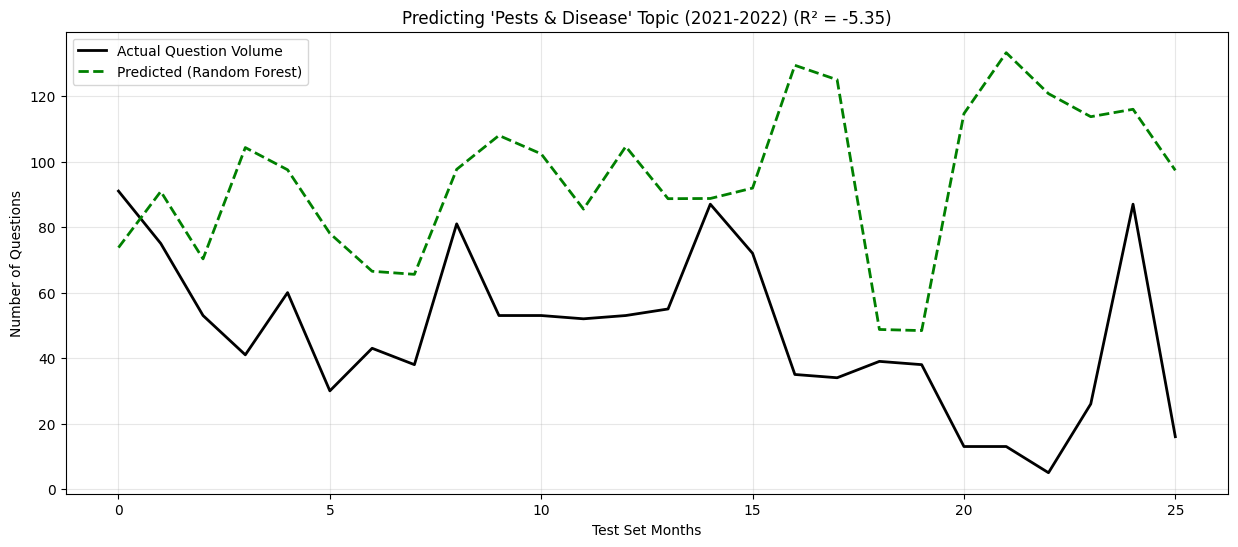

In [23]:
# Re-running to get Pest and Disease plot data
topic_df = df_model[df_model['final_category'] == 'Pests & Disease'].dropna()
X = topic_df[features_chosen]
y = topic_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
random_forest = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)

r2_value = random_forest.score(X_test, y_test)

plt.figure(figsize=(15, 6))
plt.plot(y_test.reset_index(drop=True), label='Actual Question Volume', color='black', linewidth=2)
plt.plot(predictions, label='Predicted (Random Forest)', color='green', linestyle='--', linewidth=2)

plt.title(f"Predicting 'Pests & Disease' Topic (2021-2022) (R² = {r2_value:.2f})")
plt.xlabel("Test Set Months")
plt.ylabel("Number of Questions")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("predictions_and_actual.png") 
plt.show()

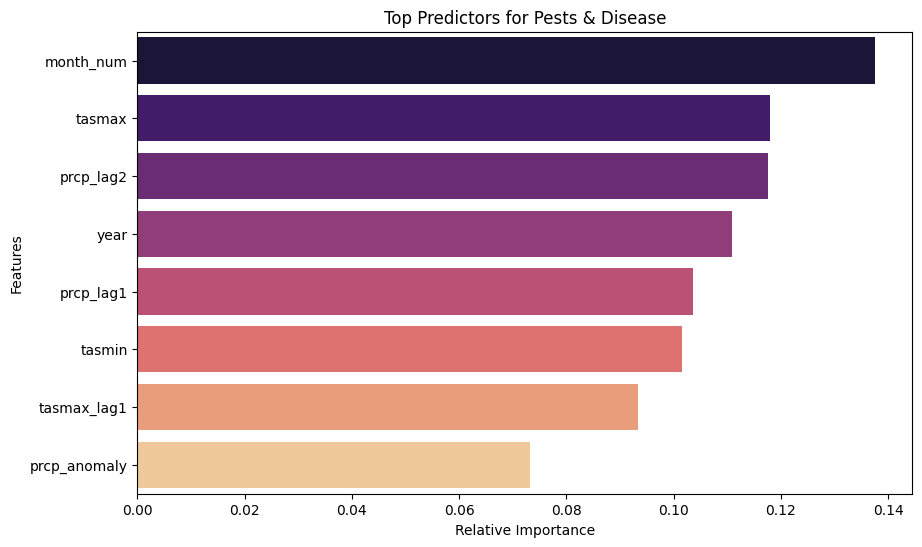

In [25]:
importance = pd.Series(random_forest.feature_importances_, index=features_chosen).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance.head(8).values, y=importance.head(8).index, hue=importance.head(8).index, palette='magma')
plt.title("Top Predictors for Pests & Disease")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.savefig("feature_importances.png") 
plt.show()